In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import os as os
import torch
import torchvision
import tarfile
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision import models
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn

import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
data_dir = '../input/chest-xray-pneumonia/chest_xray'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

pneumonia_images = os.listdir(data_dir + "/train/PNEUMONIA")
print(len(pneumonia_images))
normal_images = os.listdir(data_dir + "/train/NORMAL")
print(len(normal_images))


['val', 'train', '__MACOSX', 'test', 'chest_xray']
['NORMAL', 'PNEUMONIA']
3875
1341


In [6]:
train_tfms = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ])


val_tfms = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


test_tfms = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_ds = ImageFolder(data_dir+'/train', transform=train_tfms)
val_ds   = ImageFolder(data_dir+'/val', transform=val_tfms)
test_ds  = ImageFolder(data_dir+'/test', transform=test_tfms)

img, label = train_ds[0]
print(img.shape, label)

torch.Size([3, 224, 224]) 0


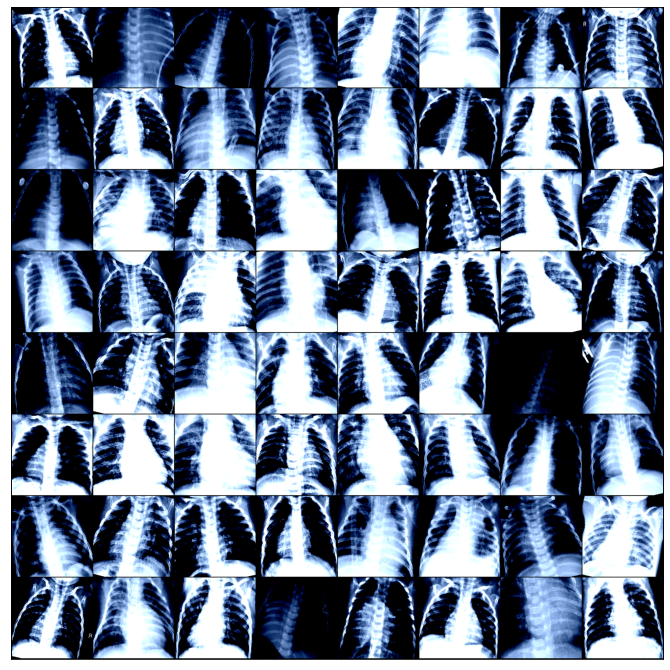

In [7]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
        
show_batch(train_dl)


In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
device = get_default_device()
print(device)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


cuda


In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


In [10]:
class x_ray(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.vgg16(pretrained=True)

        for param in self.network.parameters():
            param.requires_grad = False
        
        n_inputs = self.network.classifier[6].in_features
        self.network.classifier[6] = nn.Sequential(nn.Linear(n_inputs, 2))
        
    def forward(self, xb):
        return self.network(xb)
    



In [11]:
model = to_device(x_ray(), device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [12]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [13]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.0001

history = fit(num_epochs, lr, model, train_dl, valid_dl, opt_func)

evaluate(model, valid_dl)


Epoch [0], train_loss: 0.4659, val_loss: 0.6439, val_acc: 0.6250
Epoch [1], train_loss: 0.3432, val_loss: 0.5770, val_acc: 0.6875
Epoch [2], train_loss: 0.3012, val_loss: 0.5395, val_acc: 0.6875
Epoch [3], train_loss: 0.2794, val_loss: 0.4634, val_acc: 0.8125
Epoch [4], train_loss: 0.2660, val_loss: 0.4391, val_acc: 0.8125


{'val_loss': 0.4390511214733124, 'val_acc': 0.8125}

In [14]:
test_dl = DataLoader(test_ds, batch_size, num_workers=3, pin_memory=True)
test_dl = DeviceDataLoader(test_dl, device)
evaluate(model, test_dl)


{'val_loss': 0.49904146790504456, 'val_acc': 0.7651041746139526}

In [18]:
!pip install jovian --upgrade 


Requirement already up-to-date: jovian in /opt/conda/lib/python3.7/site-packages (0.2.16)


In [19]:
import jovian

<IPython.core.display.Javascript object>

In [ ]:
jovian.commit(project ="Course_Project")


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/harshadadesai007/Course_Project


<IPython.core.display.Javascript object>